# Jyro Homework Testbed

## I'm giving you the code I'll use to generate random robot worlds for your homework. 

### The goal of this environment it to get as close to the light source as you can within 500 steps of the simulator using an evolved controller. 
Note that trying to evolve something using 500 steps from the very begening will take a looonnnggg time (so I don't reccomend it). 

### You should feel free to manipulate the fitness function, selection methods, recombination, diversity maintenance, and the structure of the neural network brain to try and evolve better robots. 

### You may also use genetic programing to evolve a brain for this robot, in which case you'll want to also change the kinds of function nodes available to evolution.



In [29]:
from IPython.display import display, clear_output
from jyro.simulator import *
import random
import numpy as np
import pickle

#Here is the main difference, I'm just random generating some walls
#either on the left or right side of the world, evenly spaced along 
#the length of the world. 
def add_walls(sim, num_walls):
    pos_xs = np.linspace(1.5, 10, num_walls)

    for i in range(num_walls):
        width = random.uniform(0.1, 0.3)
        pos_y1 = random.choice([12-0.25, 0.25])
        length = random.uniform(3, 10)
        sim.addBox(pos_y1, pos_xs[i], length, pos_xs[i]+width, fill="gray", wallcolor="gray")

# We'll create a box for the robot to live in
# and a light source
def make_world(sim):
    sim.addBox(0, 0, 12, 12, fill="backgroundgreen", wallcolor="gray") #bounding box
    sim.addLight(11, 11, 1) #paramters are x, y, brightness
    add_walls(sim, 6)
    
#We'll give our robot the 16 sonar distance sensors, some light sensors
class MyPioneer(Pioneer):
    def __init__(self, name, x, y, angle):
        Pioneer.__init__(self, name, x, y, angle)
        self.addDevice(Pioneer16Sonars())
        #parameter defines max range in meters
        self.addDevice(PioneerFrontLightSensors(3))
        
    def move(self, linear, rotational):
        if -1 > linear > 1 or -1 > rotational > 1:
            super().move(random.uniform(-1, 1), random.uniform(-1, 1))
            print("moving randomly!")
        else:
            super().move(linear, rotational)
        


def setup_world(robot_brain):
    robot = MyPioneer("Johnny", 1, 1, 0)
    sim = Physics()
    make_world(sim)
    sim.addRobot(robot)
    robot.brain = robot_brain
    return sim, robot

### Same neural network code from before

In [30]:
class SimpleNeuralNet():
    #This is our squashing function
    #I changed this to the hyperbolic tangent function that
    #returns values in (-1, 1)
    def activation_function(self, x):
        return np.tanh(x)
    
    #this should look familiar, just a way to create a copy of 
    #the network without worying about pesky reference 
    def deepcopy(self):
        new_net = SimpleNeuralNet(self.num_inputs, self.num_outputs, self.layer_node_counts)
        new_net.layers = [np.copy(layer) for layer in self.layers]
        return new_net
    
    #this is where the neural network does its computation!
    def execute(self, input_vector):
        # First we need to make sure we're getting the right
        # number of inputs into our neural network.
        assert len(input_vector) == self.num_inputs ,\
        "wrong input vector size"

        # create a temporary variable to hold the values that should go
        # into the next layer of the network.
        # **at the start, this will just be our input**
        next_v = input_vector

        # iterate through layers, computing the activation
        # of the weighted inputs from the previous layer
        for layer in self.layers:
            # add a bias to each layer [1]
            next_v = np.append(next_v, 1)
            
            # pump the input vector through the matrix multiplication
            # and our activation function
            next_v = self.activation_function(np.dot(next_v, layer))
            
        return next_v
        
    def __init__(self, num_inputs, num_outputs, layer_node_counts=[]):
        self.num_inputs = num_inputs
        self.layer_node_counts = layer_node_counts
        self.num_outputs = num_outputs
        self.layers = []
        
        last_num_neurons = self.num_inputs
        for nc in layer_node_counts + [num_outputs]:
            # for now, we'll just use random weights in the range [-5,5]
            # +1 handles adding a bias node for each layer of nodes
            self.layers.append(np.random.uniform(-5, 5, size=(last_num_neurons+1, nc)))
            last_num_neurons = nc
    

## If you were going to use genetic programing, you'll have to change this code to generate a random GP tree instead of a random neural network

In [31]:
def network_to_brain(simple_net):
    
    #Define the brain function for jyro
    def neural_brain(a_robot):
        sonar_sensors = a_robot["sonar"].getData()
        light_sensors = a_robot["light"].getData()
        
        #combine the sonar and light inputs
        combined_input = sonar_sensors + light_sensors

        network = simple_net

        #run the neural network with the combined input values
        output = network.execute(combined_input)
        
        #use the output of the network to move the robot
        a_robot.move(output[0], output[1])

    return neural_brain

# And here are the functions you'll most likely want to play with to get better evolved robots.

In [32]:
def tournament_selection(population, fitnesses, tournament_size=3):
    sample_pop_idxs = np.random.choice(range(len(population)), size=tournament_size)
    tourny_winner_idx = np.argmax(np.array(fitnesses)[sample_pop_idxs])
    winner_pop_idx = sample_pop_idxs[tourny_winner_idx]

    return population[winner_pop_idx]
   

In [252]:
def rank_order_selection(population, fitnesses, factor=0.1):
    combined_pop = zip(population, fitnesses)
    population = [x for _,x in sorted(zip(fitnesses, population), reverse=True)]
    scaled_fitness = [(factor**float(len(population)-g))*(factor-1)/(factor**float(len(population))-1) for g in range(len(population))]
    population = random.choices(population, k=len(population), weights=scaled_fitness)
    return population

In [302]:
def elitism(population, fitnesses, num = 3):
    print(type(population[0]), type(fitnesses[0]))
    combined_pop = zip(population, fitnesses)
    population = [x for _,x in sorted(zip(fitnesses, population), reverse=True, key=lambda pair: pair[0])]
    fitnesses = sorted(fitnesses, reverse=True)
    len_pop = len(population)
    elites = population[:int(len_pop/num)]
    elites_fitness = fitnesses[:int(len_pop/num)]
    new_elites = []
    for net in range(len_pop - int(len_pop/num)):
        new_elite = random.choices(elites, k=1, weights=elites_fitness)[0]
        new_elites.append(new_elite)
        mutate_network(new_elite, mutation_rate=1)
    elites.extend(new_elites)
    population = elites
    return population

In [33]:
def mutate_network(simple_net, mutation_rate=1E-3, mutation_effect_size=2):
    for layer_to_mut in simple_net.layers:
        dims = layer_to_mut.shape
        num_mutations = np.random.binomial(dims[0]*dims[1], mutation_rate)
        for i in range(num_mutations): 
            rand_i = np.random.randint(0, dims[0])
            rand_j = np.random.randint(0, dims[1])
            layer_to_mut[rand_i, rand_j] += np.random.normal(scale=mutation_effect_size)

In [34]:
def measure_neuralnet_fitness(simple_net, iterations=500):
    this_brain = network_to_brain(simple_net)
    sim, robot = setup_world(this_brain)
    
    distance_moved = 0
    
    #reset the robot's position
    robot.setPose(1, 1, 0)
    robot.reset()
    sonar = [11, 11]
    y_2 = robot.getPose()
    y_1 = robot.getPose()
    start = math.hypot(y_2[0]-sonar[0], y_2[1] - sonar[1])
    #iterate through the simulation
    for i in range(iterations):        
        #but if the robot's stuck, end early!   
        if robot.stall:
            break
        #move the robot
        sim.step(run_brain=True)
    y_2 = robot.getPose()
    total_distance = math.hypot(y_2[0]-y_1[0], y_2[1] - y_1[1])
    end = math.hypot(y_2[0]-sonar[0], y_2[1] - sonar[1])
    return (start - end)/total_distance

In [35]:
def measure_displacement(simple_net, iterations=500):
    this_brain = network_to_brain(simple_net)
    sim, robot = setup_world(this_brain)

    distance_moved = 0
    
    #reset the robot's position
    robot.setPose(1, 1, 0)
    robot.reset()
    x = robot.getPose()
    #iterate through the simulation
    for i in range(iterations):        
        #but if the robot's stuck, end early!   
        if robot.stall:
            break
        #move the robot
        sim.step(run_brain=True)
    y = robot.getPose()
    total_distance = math.hypot(y[0]-x[0], y[1] - x[1])
    return total_distance

In [165]:
def measure_distance(simple_net, iterations=500):
    this_brain = network_to_brain(simple_net)
    sim, robot = setup_world(this_brain)

    distance_moved = 0
    
    #reset the robot's position
    robot.setPose(1, 1, 0)
    robot.reset()
    x = robot.getPose()
    #iterate through the simulation
    for i in range(iterations):        
        #but if the robot's stuck, end early!   
        if robot.stall:
            break
        #move the robot
        cur_pos = robot.getPose()
        sim.step(run_brain=True)
        next_pos = robot.getPose()
        
        #and keep track of how far it moved
        distance_moved += np.linalg.norm(np.array(cur_pos[0:2]) - np.array(next_pos[0:2]))
    return distance_moved

In [227]:
def measure_distance_to_light(simple_net, iterations=500):
    this_brain = network_to_brain(simple_net)
    sim, robot = setup_world(this_brain)
    
    distance_moved = 0
    
    #reset the robot's position
    robot.setPose(1, 1, 0)
    robot.reset()
    sonar = [11, 11]
    #iterate through the simulation
    for i in range(iterations):        
        #but if the robot's stuck, end early!   
        if robot.stall:
            break
        #move the robot
        sim.step(run_brain=True)
    end = robot.getPose()
    distance_to_light = math.hypot(sonar[0]-end[0], sonar[1] - end[1])
    return 100/distance_to_light

In [167]:
def run_evolution(pop_size, num_generations):
    #build our random population of neural networks
    population = [SimpleNeuralNet(18,2,[10]) for _ in range(pop_size)]
    evo_fitnesses = []

    for i in range(num_generations):
        #evaluate the fitnesses using 50 timesteps
        fitnesses = [measure_displacement(n) for n in population]

        #keep track of the mean pop fitnesses
        evo_fitnesses.append(np.mean(fitnesses))

        #print the generation and the mean fitness we just stuck on the
        #evo_fitnesses list
        clear_output(wait=True)
        display(i, evo_fitnesses[-1])

        #do tournament selection
        next_pop = [tournament_selection(population, fitnesses).deepcopy() for _ in range(pop_size)]

        #and mutate the new networks
        for net in next_pop:
            mutate_network(net, mutation_rate=0.1)

        population = next_pop
    return population

# These functions will work, but are probably not going to evolve very good robots. We can run them and visualize the output though.

In [37]:
#evolve 
evolved_pop = run_evolution(pop_size=30, num_generations=150)

#let's visualize the first individual in the population
#Note there is no reason to expect this is the best individual!
sim, robot = setup_world(network_to_brain(evolved_pop[0]))
canvas = Canvas((250, 250))

149

7.526025655958759

# To save your robot brain, we'll use the python `pickle` module. 
## This lets us pass a copy of our brain, and an opened file to save the object. 

In [38]:

#copy the network when we pickle it
fittest = sorted(evolved_pop, key = lambda x:(measure_displacement(x)))
pickle.dump(fittest[0].deepcopy(), open('my_robot_brain.pkl', 'wb'))

## Then, we can use `pickle.load` to read the file, and reconstruct the network object we need to control the robot! 

In [39]:
loaded_brain = pickle.load(open('my_robot_brain.pkl', 'rb'))
print(loaded_brain)

## And now we can put that loaded in brain into a robot and run it!

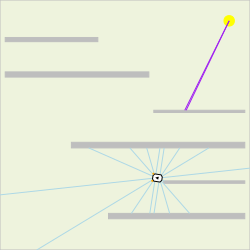

[0.0, 0.0]


In [55]:
sim, robot = setup_world(network_to_brain(loaded_brain))
canvas = Canvas((250, 250))

for i in range(500):
    sim.step(run_brain=True)
    sim.draw(canvas)
    clear_output(wait=True)
    display(canvas)
    print(robot["light"].getData())
    time.sleep(0.01)
    if robot.stall:
        break

# Homework!
## You should turn in a pickled robot brain, and a jupyter notebook that unpickles and runs your robot (just like the above code cell). That way, I know I have the right version of whatever required classes make up your brain.

In [38]:
from IPython.display import Audio

def allDone():
  os.system('say "DONE!"')

In [100]:
for x in evolved_pop:
    print(measure_neuralnet_fitness(x))

-1
0.5905970063723649
0.9667637470422888
-1
-1
0.6542304513735671
-1
0.48942775444000036
-1
0.6288235459042685
-1
0.99993674695352


In [69]:
for y in x:
    print(measure_displacement_over_distance(y))

0.7029279228152482
0.316771019180215
0.8193943904242353
0.6566526358863919
0.5999232010993941
0.9021122885856406
0.8599440873872805
0.8626644886145834
0.30247784608321593


KeyboardInterrupt: 

In [64]:
def save_population(prefix, evolved_pop):
    for i, pop in enumerate(evolved_pop):
        pickle.dump(pop.deepcopy(), open(prefix + str(i) + '.pkl', 'wb'))
def return_population(prefix, num):
    evolved = []
    for i in range(num):
        evolved.append(pickle.load(open(prefix + str(i) + '.pkl', 'rb')))
    return evolved
def delete_population(prefix, num):
    for i in range(num):
        os.remove(prefix + str(i) + '.pkl')

In [72]:
save_population('displacement', fittest)

In [168]:
fittest = return_population('displacement', 30)

In [71]:
delete_population('displacement', 30)

In [246]:
def run_evolution_with_fitness(pop, num_generations, fitness_func, repopulating_func = tournament_selection):
    #build our random population of neural networks
    population = pop
    evo_fitnesses = []

    for i in range(num_generations):
        #evaluate the fitnesses using 50 timesteps
        fitnesses = [fitness_func(n) for n in population]

        #keep track of the mean pop fitnesses
        evo_fitnesses.append(np.mean(fitnesses))

        #print the generation and the mean fitness we just stuck on the
        #evo_fitnesses list
        clear_output(wait=True)
        display(i, evo_fitnesses[-1])

        #do tournament selection
        next_pop = repopulating_func(population, fitnesses)

        #and mutate the new networks
        for net in next_pop:
            mutate_network(net, mutation_rate=0.1)

        population = next_pop
    return population

In [216]:
new_fittest = run_evolution_with_fitness(fittest, 25, measure_displacement)

24

7.544696236289764

In [217]:
new_fittest_sorted = sorted(new_fittest, key = lambda x:(measure_displacement(x)))

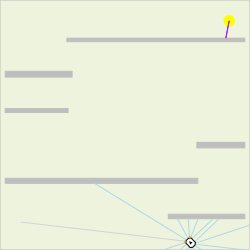

[0.0, 0.0]


In [271]:
sim, robot = setup_world(network_to_brain(new_fittest_sorted[0]))
canvas = Canvas((250, 250))

for i in range(500):
    sim.step(run_brain=True)
    sim.draw(canvas)
    clear_output(wait=True)
    display(canvas)
    print(robot["light"].getData())
    time.sleep(0.01)
    if robot.stall:
        break

In [220]:
delete_population('distance_over_displacement', 30)
save_population('distance_over_displacement', new_fittest_sorted)

In [304]:
distance_to_light_50 = run_evolution_with_fitness(new_fittest, 5, measure_distance_to_light, elitism)

4

7.871717235615893

<class '__main__.SimpleNeuralNet'> <class 'float'>


In [305]:
distance_to_light_fittest = sorted(distance_to_light_50, key = lambda x:(measure_distance_to_light(x)), reverse=True)

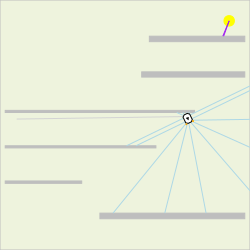

[0.0, 0.0]


In [280]:
sim, robot = setup_world(network_to_brain(new_fittest[0]))
canvas = Canvas((250, 250))

for i in range(500):
    sim.step(run_brain=True)
    sim.draw(canvas)
    clear_output(wait=True)
    display(canvas)
    print(robot["light"].getData())
    time.sleep(0.001)
    if robot.stall:
        break

In [122]:
robot.getPose()

(1.2090819207909915, 0.2617321346943963, 0.11657911392967957)

In [283]:
sorted([93, 5, 1], reverse=True)

[93, 5, 1]